# Dependencies

In [1]:
!pip install --user pyarrow -U
!pip install --user fastparquet -U
!pip install --user shap -U

In [2]:
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import pyplot

import sklearn as sk
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance

from pathlib import Path

from scipy.stats import zscore

import shap

# Figures

## Load Dataset

## Figures

In [3]:
df = pd.read_csv("processed_6h_c.csv")
print(df)

      subject        date      ki04      ki10      ki16      ki22       f04  \
0           1  2019-03-10 -0.205910  1.395246  0.209204 -0.976837  0.593548   
1           1  2019-03-11 -0.383816 -1.273347 -0.205910 -1.036139 -0.022829   
2           1  2019-03-12 -0.976837 -1.273347 -0.739628 -1.154743 -0.793300   
3           1  2019-03-13 -0.798931 -1.273347 -0.146608 -0.858233 -0.176923   
4           1  2019-03-14 -0.976837 -1.273347 -0.621024 -0.976837 -0.485112   
...       ...         ...       ...       ...       ...       ...       ...   
3046       25  2020-06-06 -1.215480  1.182785  0.854255 -0.755539 -1.218391   
3047       25  2020-06-07 -0.886950  0.295755  0.591432 -0.197039 -0.825179   
3048       25  2020-06-08 -0.624127  0.821402  0.065785 -0.689833  0.092317   
3049       25  2020-06-09 -0.985509  0.361461  0.689991 -0.525568 -0.563037   
3050       25  2020-06-10 -1.182627  1.806990  2.529755 -0.624127 -0.956249   

           f10       f16       f22      ke04      k

In [4]:
df['date'] = pd.to_datetime(df['date'])
mask1 = (df['date'] > '2019-3-09') & (df['date'] <= '2019-6-10')
pre = df.loc[mask1]
mask2 = (df['date'] > '2020-3-09') & (df['date'] <= '2020-6-10')
COVID = df.loc[mask2]
print(pre)
print(COVID)

      subject       date      ki04      ki10      ki16      ki22       f04  \
0           1 2019-03-10 -0.205910  1.395246  0.209204 -0.976837  0.593548   
1           1 2019-03-11 -0.383816 -1.273347 -0.205910 -1.036139 -0.022829   
2           1 2019-03-12 -0.976837 -1.273347 -0.739628 -1.154743 -0.793300   
3           1 2019-03-13 -0.798931 -1.273347 -0.146608 -0.858233 -0.176923   
4           1 2019-03-14 -0.976837 -1.273347 -0.621024 -0.976837 -0.485112   
...       ...        ...       ...       ...       ...       ...       ...   
2953       25 2019-06-04 -0.854097  0.460020  0.558579 -0.985509 -1.218391   
2954       25 2019-06-05 -1.215480  0.295755 -0.098480 -0.361303 -1.218391   
2955       25 2019-06-06 -0.952656 -0.722686 -1.215480 -1.215480 -0.431966   
2956       25 2019-06-09 -1.215480 -1.215480 -1.215480 -0.459862 -1.218391   
2957       25 2019-06-10 -0.361303  0.952814  0.295755 -0.886950 -0.169825   

           f10       f16       f22      ke04      ke10      ke1

In [5]:
pre = pre.groupby(["subject"]).mean()
pre = pre.reset_index()
print(pre)
COVID = COVID.groupby(["subject"]).mean()
COVID = COVID.reset_index()
print(COVID)

    subject      ki04      ki10      ki16      ki22       f04       f10  \
0         1 -0.108577  0.517317  0.583710 -0.840184  0.317184  0.315509   
1         2 -0.832005  0.134059  0.262157 -0.732649 -0.668642  0.447624   
2         3 -0.906226  0.264159  0.226340 -0.951509 -0.713830  0.621306   
3         4 -0.640297  0.355683  0.013242 -0.747092 -0.423443  1.212526   
4         5 -0.855676 -0.110328 -0.032233 -0.914248 -0.822064  0.130720   
5         6 -0.472657  0.220214 -0.202501 -1.088613 -0.355882  0.358587   
6         7 -0.509428  0.035540 -0.136534 -0.543593 -0.326018  1.113543   
7         8 -1.315830  0.290344 -0.266767 -0.472018 -1.064482  0.512080   
8         9 -0.066831  2.132896  1.531287 -0.310560 -0.340144  1.005623   
9        10 -0.171509 -0.045174 -0.368686 -1.047590  0.060460  0.176887   
10       11 -0.561266  0.674815  0.301823 -0.851853 -0.608142  0.770339   
11       12 -0.143297  0.208600 -0.083886 -1.027610 -0.022608  0.325333   
12       13 -0.530102  0.

In [6]:
pre_1 = pre[pre["subject"].isin([21, 24, 3, 23, 4, 15, 5, 14])]
pre_2 = pre[pre["subject"].isin([16, 12, 17, 13, 18, 2, 20])]
pre_3 = pre[pre["subject"].isin([1, 9, 10])]
pre_4 = pre[pre["subject"].isin([22, 8, 19, 7, 11, 6, 25])]
print(pre_1)
print(pre_2)
print(pre_3)
print(pre_4)

    subject      ki04      ki10      ki16      ki22       f04       f10  \
2         3 -0.906226  0.264159  0.226340 -0.951509 -0.713830  0.621306   
3         4 -0.640297  0.355683  0.013242 -0.747092 -0.423443  1.212526   
4         5 -0.855676 -0.110328 -0.032233 -0.914248 -0.822064  0.130720   
13       14 -0.737054  0.000982 -0.426821 -0.873587 -0.715721  0.865118   
14       15 -0.865482  0.139584  0.516369 -0.857191 -0.251404  1.180729   
20       21 -0.576710  0.594451  0.511611 -0.963991 -0.395982  0.700570   
22       23 -0.925133  0.399483  0.239108 -0.838855 -0.812013  0.832632   
23       24 -0.437017  0.901182  0.104487 -0.723329 -0.576178  1.318206   

         f16       f22      ke04      ke10      ke16      ke22      ov04  \
2   0.775136 -0.887978 -0.389736  0.373764  0.484270 -0.942269 -0.423128   
3   0.111017 -0.794958 -0.378742  0.558268 -0.130147 -0.722949 -0.493540   
4   0.478853 -0.904516 -0.774908  0.204307  0.091938 -0.839119 -0.386799   
13 -0.017568 -0.8356

In [7]:
COVID_1 = COVID[COVID["subject"].isin([21, 24, 3, 23, 4, 15, 5, 14])]
COVID_2 = COVID[COVID["subject"].isin([16, 12, 17, 13, 18, 2, 20])]
COVID_3 = COVID[COVID["subject"].isin([1, 9, 10])]
COVID_4 = COVID[COVID["subject"].isin([22, 8, 19, 7, 11, 6, 25])]
print(COVID_1)
print(COVID_2)
print(COVID_3)
print(COVID_4)

    subject      ki04      ki10      ki16      ki22       f04       f10  \
2         3 -0.790721  1.284163  0.983391 -0.800566 -0.782147  0.729571   
3         4 -0.764529  1.233803  0.974521 -0.815382 -0.637560  1.115869   
4         5 -0.799661  1.233132  0.979336 -0.837005 -0.770987  1.143250   
13       14 -0.301380  1.590653  0.594175 -0.876156 -0.472785  1.398348   
14       15 -0.945946  0.747885  1.504090 -0.675173 -0.478901 -0.256246   
20       21 -0.468528  0.764419  1.063192 -0.791636 -0.483189  0.327403   
22       23 -0.948479  1.109961  1.011962 -0.677302 -0.864576  1.013883   
23       24 -0.687762  0.786835  0.526486 -0.572526 -0.680879  0.841726   

         f16       f22      ke04      ke10      ke16      ke22      ov04  \
2   0.972192 -0.818038 -0.397298  0.969181  0.422590 -0.760036 -0.383447   
3   0.287414 -0.830598 -0.382810  1.068476  0.454924 -0.724983 -0.470900   
4   0.831566 -0.867526 -0.434867  1.440366  0.145102 -0.753850 -0.401470   
13  0.356294 -0.9337

In [8]:
pre_1 = pre_1.drop(["subject"], axis=1)
pre_2 = pre_2.drop(["subject"], axis=1)
pre_3 = pre_3.drop(["subject"], axis=1)
pre_4 = pre_4.drop(["subject"], axis=1)
COVID_1 = COVID_1.drop(["subject"], axis=1)
COVID_2 = COVID_2.drop(["subject"], axis=1)
COVID_3 = COVID_3.drop(["subject"], axis=1)
COVID_4 = COVID_4.drop(["subject"], axis=1)

In [9]:
pre_1 = pre_1.mean(axis=0)
pre_2 = pre_2.mean(axis=0)
pre_3 = pre_3.mean(axis=0)
pre_4 = pre_4.mean(axis=0)
COVID_1 = COVID_1.mean(axis=0)
COVID_2 = COVID_2.mean(axis=0)
COVID_3 = COVID_3.mean(axis=0)
COVID_4 = COVID_4.mean(axis=0)

In [10]:
print(pre_1)

ki04   -0.742949
ki10    0.318150
ki16    0.144013
ki22   -0.858725
f04    -0.588829
f10     0.857726
f16     0.560554
f22    -0.770487
ke04   -0.321218
ke10    0.717227
ke16    0.090635
ke22   -0.734412
ov04   -0.312906
ov10    0.625102
ov16   -0.223424
ov22   -0.450399
dtype: float64


In [11]:
pre_1 = pre_1.to_frame()
pre_1.columns = ['Values']
pre_2 = pre_2.to_frame()
pre_2.columns = ['Values']
pre_3 = pre_3.to_frame()
pre_3.columns = ['Values']
pre_4 = pre_4.to_frame()
pre_4.columns = ['Values']
COVID_1 = COVID_1.to_frame()
COVID_1.columns = ['Values']
COVID_2 = COVID_2.to_frame()
COVID_2.columns = ['Values']
COVID_3 = COVID_3.to_frame()
COVID_3.columns = ['Values']
COVID_4 = COVID_4.to_frame()
COVID_4.columns = ['Values']

In [12]:
Location = ['Kitchen','Kitchen','Kitchen','Kitchen','Fridge Door','Fridge Door','Fridge Door','Fridge Door','Kettle','Kettle','Kettle','Kettle','Oven','Oven','Oven','Oven']
TimeofDay = ['2am-8am','8am-2pm','2pm-8pm','8pm-2am','2am-8am','8am-2pm','2pm-8pm','8pm-2am','2am-8am','8am-2pm','2pm-8pm','8pm-2am','2am-8am','8am-2pm','2pm-8pm','8pm-2am']
#TimeofDay = ['Night','Breakfast','Lunch','Dinner','Night','Breakfast','Lunch','Dinner','Night','Breakfast','Lunch','Dinner','Night','Breakfast','Lunch','Dinner']
pre_1['Location'] = Location
pre_1['Time of Day'] = TimeofDay
pre_2['Location'] = Location
pre_2['Time of Day'] = TimeofDay
pre_3['Location'] = Location
pre_3['Time of Day'] = TimeofDay
pre_4['Location'] = Location
pre_4['Time of Day'] = TimeofDay
COVID_1['Location'] = Location
COVID_1['Time of Day'] = TimeofDay
COVID_2['Location'] = Location
COVID_2['Time of Day'] = TimeofDay
COVID_3['Location'] = Location
COVID_3['Time of Day'] = TimeofDay
COVID_4['Location'] = Location
COVID_4['Time of Day'] = TimeofDay

In [13]:
pre_1 = pd.pivot_table(pre_1, values='Values', index='Location', columns='Time of Day')
pre_1 = pre_1[["2am-8am", "8am-2pm", "2pm-8pm", "8pm-2am"]]
pre_2 = pd.pivot_table(pre_2, values='Values', index='Location', columns='Time of Day')
pre_2 = pre_2[["2am-8am", "8am-2pm", "2pm-8pm", "8pm-2am"]]
pre_3 = pd.pivot_table(pre_3, values='Values', index='Location', columns='Time of Day')
pre_3 = pre_3[["2am-8am", "8am-2pm", "2pm-8pm", "8pm-2am"]]
pre_4 = pd.pivot_table(pre_4, values='Values', index='Location', columns='Time of Day')
pre_4 = pre_4[["2am-8am", "8am-2pm", "2pm-8pm", "8pm-2am"]]
COVID_1 = pd.pivot_table(COVID_1, values='Values', index='Location', columns='Time of Day')
COVID_1 = COVID_1[["2am-8am", "8am-2pm", "2pm-8pm", "8pm-2am"]]
COVID_2 = pd.pivot_table(COVID_2, values='Values', index='Location', columns='Time of Day')
COVID_2 = COVID_2[["2am-8am", "8am-2pm", "2pm-8pm", "8pm-2am"]]
COVID_3 = pd.pivot_table(COVID_3, values='Values', index='Location', columns='Time of Day')
COVID_3 = COVID_3[["2am-8am", "8am-2pm", "2pm-8pm", "8pm-2am"]]
COVID_4 = pd.pivot_table(COVID_4, values='Values', index='Location', columns='Time of Day')
COVID_4 = COVID_4[["2am-8am", "8am-2pm", "2pm-8pm", "8pm-2am"]]

In [14]:
print(pre_1)

Time of Day   2am-8am   8am-2pm   2pm-8pm   8pm-2am
Location                                           
Fridge Door -0.588829  0.857726  0.560554 -0.770487
Kettle      -0.321218  0.717227  0.090635 -0.734412
Kitchen     -0.742949  0.318150  0.144013 -0.858725
Oven        -0.312906  0.625102 -0.223424 -0.450399


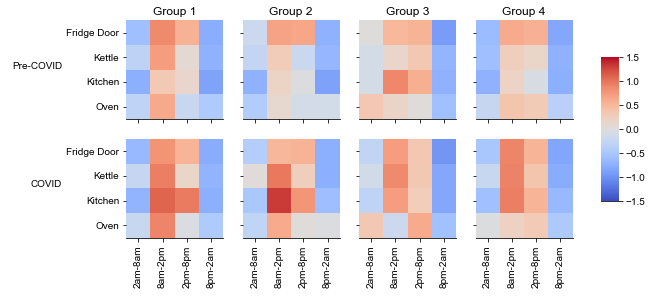

In [15]:
rows = ['{}COVID'.format(row) for row in ['Pre-','']]
cols = ['Group {}'.format(row) for row in ['1','2','3','4']]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 4), sharey=True, sharex=True)

cbar_ax = fig.add_axes([.95,.2525,.03,.5])

sns.heatmap(pre_1, cmap="coolwarm", ax=axes[0,0], cbar=True, vmin=-1.5, vmax=1.5, cbar_ax = cbar_ax)
axes[0,0].set_xlabel(None)
axes[0,0].set_ylabel(None)
sns.heatmap(COVID_1, cmap="coolwarm", ax=axes[1,0], cbar=True, vmin=-1.5, vmax=1.5, cbar_ax = cbar_ax)
axes[1,0].set_xlabel(None)
axes[1,0].set_ylabel(None)

sns.heatmap(pre_2, cmap="coolwarm", ax=axes[0,1], cbar=True, vmin=-1.5, vmax=1.5, cbar_ax = cbar_ax)
axes[0,1].set_xlabel(None)
axes[0,1].set_ylabel(None)
sns.heatmap(COVID_2, cmap="coolwarm", ax=axes[1,1], cbar=True, vmin=-1.5, vmax=1.5, cbar_ax = cbar_ax)
axes[1,1].set_xlabel(None)
axes[1,1].set_ylabel(None)

sns.heatmap(pre_3, cmap="coolwarm", ax=axes[0,2], cbar=True, vmin=-1.5, vmax=1.5, cbar_ax = cbar_ax)
axes[0,2].set_xlabel(None)
axes[0,2].set_ylabel(None)
sns.heatmap(COVID_3, cmap="coolwarm", ax=axes[1,2], cbar=True, vmin=-1.5, vmax=1.5, cbar_ax = cbar_ax)
axes[1,2].set_xlabel(None)
axes[1,2].set_ylabel(None)

sns.heatmap(pre_4, cmap="coolwarm", ax=axes[0,3], cbar=True, vmin=-1.5, vmax=1.5, cbar_ax = cbar_ax)
axes[0,3].set_xlabel(None)
axes[0,3].set_ylabel(None)
sns.heatmap(COVID_4, cmap="coolwarm", ax=axes[1,3], cbar=True, vmin=-1.5, vmax=1.5, cbar_ax = cbar_ax)
axes[1,3].set_xlabel(None)
axes[1,3].set_ylabel(None)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, ha='right')
for ax, col in zip(axes[0], cols):
    ax.set_title(col, rotation=0)
    
sns.set(font_scale=1.3)
sns.set(style="whitegrid")
sns.despine(left=True)
plt.show()

### Figure C

In [16]:
df = pd.read_csv('labelled_c.csv')
df = df.iloc[:, 1:20]
print(df)

      subject        date      ki04      ki10      ki16      ki22       f04  \
0           1  2019-03-10 -0.205910  1.395246  0.209204 -0.976837  0.593548   
1           1  2019-03-11 -0.383816 -1.273347 -0.205910 -1.036139 -0.022829   
2           1  2019-03-12 -0.976837 -1.273347 -0.739628 -1.154743 -0.793300   
3           1  2019-03-13 -0.798931 -1.273347 -0.146608 -0.858233 -0.176923   
4           1  2019-03-14 -0.976837 -1.273347 -0.621024 -0.976837 -0.485112   
...       ...         ...       ...       ...       ...       ...       ...   
3046       25  2020-06-06 -1.215480  1.182785  0.854255 -0.755539 -1.218391   
3047       25  2020-06-07 -0.886950  0.295755  0.591432 -0.197039 -0.825179   
3048       25  2020-06-08 -0.624127  0.821402  0.065785 -0.689833  0.092317   
3049       25  2020-06-09 -0.985509  0.361461  0.689991 -0.525568 -0.563037   
3050       25  2020-06-10 -1.182627  1.806990  2.529755 -0.624127 -0.956249   

           f10       f16       f22      ke04      k

In [17]:
df.columns = ['subject','date','Kitchen, 2am-8am','Kitchen, 8am-2pm','Kitchen, 2pm-8pm','Kitchen, 8pm-2am','Fridge Door, 2am-8am','Fridge Door, 8am-2pm','Fridge Door, 2pm-8pm','Fridge Door, 8pm-2am','Kettle, 2am-8am','Kettle, 8am-2pm','Kettle, 2pm-8pm','Kettle, 8pm-2am','Oven, 2am-8am','Oven, 8am-2pm','Oven, 2pm-8pm','Oven, 8pm-2am','Class']

In [18]:
df_1 = df[df["subject"].isin([21, 24, 3, 23, 4, 15, 5, 14])]
df_2 = df[df["subject"].isin([16, 12, 17, 13, 18, 2, 20])]
df_3 = df[df["subject"].isin([1, 9, 10])]
df_4 = df[df["subject"].isin([22, 8, 19, 7, 11, 6, 25])]
print(df_1)
print(df_2)
print(df_3)
print(df_4)

      subject        date  Kitchen, 2am-8am  Kitchen, 8am-2pm  \
178         3  2019-04-24         -1.220220         -0.144381   
179         3  2019-04-25         -0.968428          0.771226   
180         3  2019-04-26         -1.037098          0.427873   
181         3  2019-04-27         -1.014208          1.320591   
182         3  2019-04-28         -1.037098          0.771226   
...       ...         ...               ...               ...   
2953       24  2020-06-06         -0.922503         -0.922503   
2954       24  2020-06-07         -0.922503         -0.847813   
2955       24  2020-06-08         -0.922503         -0.847813   
2956       24  2020-06-09         -0.922503          0.272540   
2957       24  2020-06-10         -0.922503         -0.922503   

      Kitchen, 2pm-8pm  Kitchen, 8pm-2am  Fridge Door, 2am-8am  \
178           0.404983         -1.059988             -1.059223   
179           0.359203         -1.105769             -1.059223   
180           0.35920

In [72]:
ix =  np.argsort(clf.feature_importances_)[::-1]
ix

array([ 2,  1,  3,  9,  4,  6,  0, 15,  5, 13, 11,  7, 12,  8, 14, 10])

array([-1.31413871,  0.24316634,  0.99408392, ..., -0.03295107,
        0.59313272,  0.78325336])

In [109]:
rng = np.random.default_rng()
jitter_strength = 0.05
shap_dataframe["factors"],features = pd.factorize(shap_dataframe.feature)
n = shap_dataframe.shape[0]
shap_dataframe["y_jitter"] = shap_dataframe["shap"]+shap_dataframe["factors"]+ rng.normal(size=(n,))*jitter_strength


In [120]:
shap_dataframe

,feature,shap,factors,y_jitter
0,"Kitchen, 2am-8am",-0.138085,0,-0.175454
1,"Kitchen, 2am-8am",-0.150308,0,-0.099624
2,"Kitchen, 2am-8am",-0.155304,0,-0.160066
3,"Kitchen, 2am-8am",-0.095036,0,-0.079343
4,"Kitchen, 2am-8am",-0.144523,0,-0.187368
...,...,...,...,...
14187,"Oven, 8pm-2am",0.000203,15,14.990769
14188,"Oven, 8pm-2am",-0.000029,15,15.107905
14189,"Oven, 8pm-2am",0.000203,15,14.994243
14190,"Oven, 8pm-2am",-0.000029,15,14.963847


In [119]:
X.unstack()

Kitchen, 2am-8am  178    -1.220220
                  179    -0.968428
                  180    -1.037098
                  181    -1.014208
                  182    -1.037098
                            ...   
Oven, 8pm-2am     2953   -0.374872
                  2954   -0.374872
                  2955   -0.374872
                  2956   -0.374872
                  2957   -0.374872
Length: 14192, dtype: float64

In [ ]:
X.unstack().values

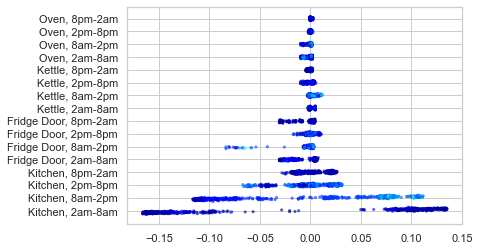

In [127]:
fig,ax = plt.subplots()
ax.scatter(shap_dataframe["shap"],shap_dataframe["y_jitter"],s=5,alpha=0.5,c=X.unstack().values,cmap='jet' )
ax.set_yticks(range(X.shape[1]))
ax.set_yticklabels(features);

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


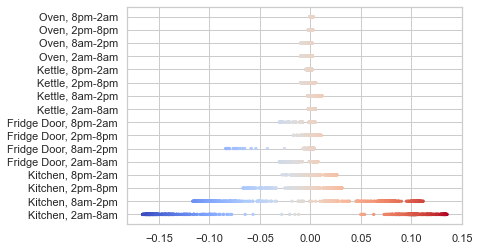

In [89]:
shap_dataframe = pd.DataFrame(shap_values[1][:,ix],columns=X.columns).unstack().reset_index().drop('level_1',1).rename(columns={'level_0':'feature',0:'shap'})
fig,ax = plt.subplots()
ax.scatter(x = shap_dataframe['shap'],y=shap_dataframe['feature'],s=5,c=shap_dataframe['shap'],cmap='coolwarm')


In [116]:
explainer = shap.TreeExplainer(clf,X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values[1],order=features)

IndexError: tuple index out of range

In [ ]:
shap_exp.feature_perturbation

In [117]:
rng = np.random.default_rng()
jitter_strength = 0.05

# for df_ in [df_1,df_2,df_3,df_4]:
df_ = df_1
X,y = df_.drop(['Class','date','subject'],axis=1),df_.Class
clf = RandomForestClassifier(max_depth=2, random_state=1).fit(X, y)
shap_exp = shap.TreeExplainer(clf,feature_names=X.columns)
shap_values = shap_exp.shap_values(X)
features = shap_exp.feature_names
shap_dataframe = pd.DataFrame(shap_values[1][:,ix],columns=X.columns).unstack().reset_index().drop('level_1',1).rename(columns={'level_0':'feature',0:'shap'})
shap_dataframe["factors"],features = pd.factorize(shap_dataframe.feature)
n = shap_dataframe.shape[0]
shap_dataframe["y_jitter"] = shap_dataframe["shap"]+shap_dataframe["factors"]+ rng.normal(size=(n,))*jitter_strength



In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


Text(0.5, 1.0, 'Group 1: RF')

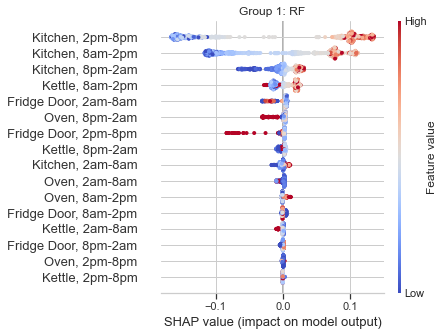

In [19]:
X = df_1.drop(['Class','date','subject'],axis=1)
Y = df_1.Class
clf = RandomForestClassifier(max_depth=2, random_state=1)
clf.fit(X, Y)

# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(clf).shap_values(X)

# visualize the first prediction's explanation
shap.summary_plot(shap_values[1], X, max_display=20, show=False, plot_size=[5,5], cmap='coolwarm')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.title("Group 1: RF")

Text(0.5, 1.0, 'Group 1: XGBoost')

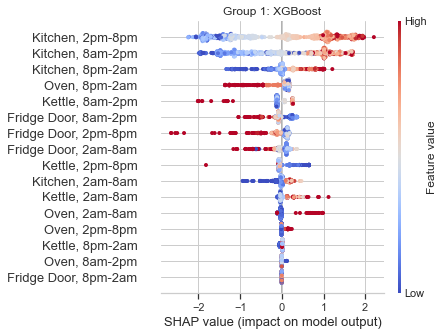

In [20]:
X = df_1.drop(['Class','date','subject'],axis=1)
Y = df_1.Class
clf = GradientBoostingClassifier(max_depth=2, random_state=1)
clf.fit(X, Y)

# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(clf).shap_values(X)

# visualize the first prediction's explanation
shap.summary_plot(shap_values, X, max_display=20, show=False, plot_size=[5,5], cmap="coolwarm")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.title("Group 1: XGBoost")

Text(0.5, 1.0, 'Group 2: RF')

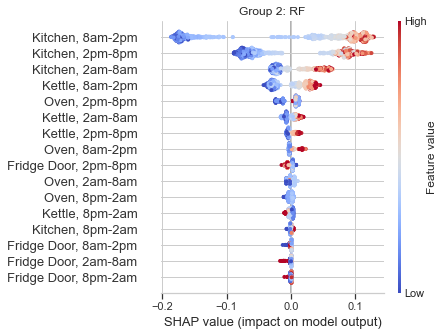

In [21]:
X = df_2.drop(['Class','date','subject'],axis=1)
Y = df_2.Class
clf = RandomForestClassifier(max_depth=2, random_state=1)
clf.fit(X, Y)

# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(clf).shap_values(X)

# visualize the first prediction's explanation
shap.summary_plot(shap_values[1], X, max_display=20, show=False, plot_size=[5,5], cmap="coolwarm")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.title("Group 2: RF")

Text(0.5, 1.0, 'Group 2: XGBoost')

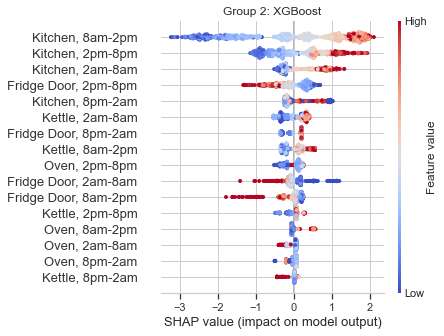

In [22]:
X = df_2.drop(['Class','date','subject'],axis=1)
Y = df_2.Class
clf = GradientBoostingClassifier(max_depth=2, random_state=1)
clf.fit(X, Y)

# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(clf).shap_values(X)

# visualize the first prediction's explanation
shap.summary_plot(shap_values, X, max_display=20, show=False, plot_size=[5,5], cmap="coolwarm")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.title("Group 2: XGBoost")

Text(0.5, 1.0, 'Group 3: RF')

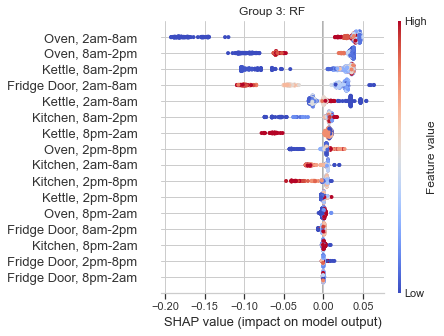

In [23]:
X = df_3.drop(['Class','date','subject'],axis=1)
Y = df_3.Class
clf = RandomForestClassifier(max_depth=2, random_state=1)
clf.fit(X, Y)

# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(clf).shap_values(X)

# visualize the first prediction's explanation
shap.summary_plot(shap_values[1], X, max_display=20, show=False, plot_size=[5,5], cmap="coolwarm")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.title("Group 3: RF")

Text(0.5, 1.0, 'Group 3: XGBoost')

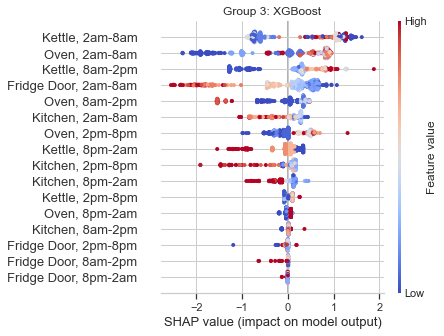

In [24]:
X = df_3.drop(['Class','date','subject'],axis=1)
Y = df_3.Class
clf = GradientBoostingClassifier(max_depth=2, random_state=1)
clf.fit(X, Y)

# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(clf).shap_values(X)

# visualize the first prediction's explanation
shap.summary_plot(shap_values, X, max_display=20, show=False, plot_size=[5,5], cmap="coolwarm")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.title("Group 3: XGBoost")

Text(0.5, 1.0, 'Group 4: RF')

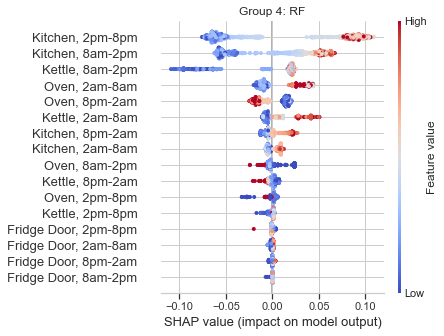

In [25]:
X = df_4.drop(['Class','date','subject'],axis=1)
Y = df_4.Class
clf = RandomForestClassifier(max_depth=2, random_state=1)
clf.fit(X, Y)

# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(clf).shap_values(X)

# visualize the first prediction's explanation
shap.summary_plot(shap_values[1], X, max_display=20, show=False, plot_size=[5,5], cmap="coolwarm")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.title("Group 4: RF")

In [33]:
shap_values

array([[-4.48914856e-02, -6.67523591e-01, -7.32989290e-01, ...,
        -6.42427525e-03, -1.97074203e-01,  5.86374646e-02],
       [-1.63391421e-02, -7.12451589e-01, -7.32989290e-01, ...,
        -6.42427525e-03, -2.01900075e-01,  5.86374646e-02],
       [-1.63391421e-02, -7.45975105e-01, -7.32989290e-01, ...,
        -6.42427525e-03, -2.01900075e-01,  5.86374646e-02],
       ...,
       [-9.64398541e-02, -1.00001905e-01, -5.41084270e-01, ...,
         1.56765422e-02,  7.03772261e-02,  8.85328026e-02],
       [-3.44305779e-02, -6.02629075e-01,  7.94118980e-01, ...,
         1.56765422e-02,  7.35187519e-02,  1.72668010e-01],
       [-4.19300403e-02,  1.00823570e+00,  1.00735754e+00, ...,
        -3.22986344e-04,  7.25056760e-02,  1.72668010e-01]])

In [31]:
shap.summary_plot?

Signature:
shap.summary_plot(
    shap_values,
    features=None,
    feature_names=None,
    max_display=None,
    plot_type=None,
    color=None,
    axis_color='#333333',
    title=None,
    alpha=1,
    show=True,
    sort=True,
    color_bar=True,
    plot_size='auto',
    layered_violin_max_num_bins=20,
    class_names=None,
    class_inds=None,
    color_bar_label='Feature value',
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7fc432aa41f0>,
    auto_size_plot=None,
    use_log_scale=False,
)
Docstring:
Create a SHAP beeswarm plot, colored by feature values when they are provided.

Parameters
----------
shap_values : numpy.array
    For single output explanations this is a matrix of SHAP values (# samples x # features).
    For multi-output explanations this is a list of such matrices of SHAP values.

features : numpy.array or pandas.DataFrame or list
    Matrix of feature values (# samples x # features) or a feature_names list as shorthand

feature_names : list

Text(0.5, 1.0, 'Group 4: XGBoost')

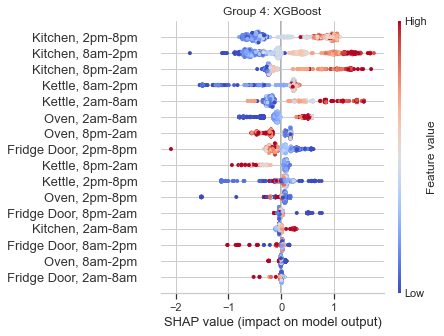

In [26]:
X = df_4.drop(['Class','date','subject'],axis=1)
Y = df_4.Class
clf = GradientBoostingClassifier(max_depth=2, random_state=1)
clf.fit(X, Y)

# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(clf).shap_values(X)

# visualize the first prediction's explanation
shap.summary_plot(shap_values, X, max_display=20, show=False, plot_size=[5,5], cmap="coolwarm")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.title("Group 4: XGBoost")